In [1]:
from lib.environments import BurgersEnvironment
from lib.models import BurgersIRCNN
from lib.models.wrappers import MarlModel
from tianshou.utils.net.common import ActorCritic
from lib.policy.ppo import MarlPPOPolicy
from lib.distributions import ElementwiseNormal

import torch
import math
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import pickle
import os

# Plotting settings
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
FONT_SIZE = 16
FIG_SIZE = (4, 3.5)
plt.rcParams['figure.figsize'] = FIG_SIZE
# Set global font size
plt.rcParams['font.size'] = FONT_SIZE
plt.rcParams['axes.labelsize'] = FONT_SIZE
plt.rcParams['xtick.labelsize'] = FONT_SIZE
plt.rcParams['ytick.labelsize'] = FONT_SIZE
plt.rcParams['legend.fontsize'] = 12

# This serves to assure Type 1 fonts
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['ps.useafm'] = True

In [2]:
def plot_n(ims, titles=None):   
    fig, axes = plt.subplots(1, len(ims), figsize=(7, 5))
    for i, (ax, im) in enumerate(zip(axes, ims)):
        ax.imshow(im, interpolation="none", cmap="viridis")
        ax.axis("off")
        if titles:
            ax.set_title(titles[i])
    plt.show()

# Alternative way to plot 2D velocity fields
def plot_quivers(u_bar_no_rl, v_bar_no_rl, env):  
    fig, axes = plt.subplots(1, 3)
    fig.set_figheight(3)
    fig.set_figwidth(9)

    axes[0].quiver(u_bar_no_rl, v_bar_no_rl)
    axes[1].quiver(env.u_cgs, env.v_cgs)
    axes[2].quiver(*env.get_coarse_grid_repr_of_fgs_velocities())
    plt.show()

method_color = {
    "CGS": "red",
    "ACGS": "orange",
    "FGS": "green",
    "CNN-MARL": "blue"
}

In [3]:
class Collector:
    def __init__(self, names):
        self.values = {name: [] for name in names}

    def add(self, name, value):
        self.values[name].append(value)

    def post_collection_processing(self):
        for key, value in self.values.items():
            self.values[key] = np.array(self.values[key])

    def __call__(self, name):
        return self.values[name]

    def __repr__(self):
        self.post_collection_processing()
        description = "Collector( \n"
        for key, value in self.values.items():
            description += f"{key}: {value.shape}, \n"
        description += ")"
        return description

    def load_collection(self, col):
        for key, value in col.values.items():
            self.add(key, value)


def save_col(_col, path):
    with open(path, 'wb') as f:
        pickle.dump(_col, f)

def load_col(path):
    with open(path, 'rb') as f:
        loaded_data = pickle.load(f)
        return loaded_data


def plot_collection(ks, col, label, color, log=False):
    plt.plot(ks, col.mean(axis=0), label=label, color=color)
    plt.fill_between(ks,
                     col.mean(axis=0) - col.std(axis=0),
                     col.mean(axis=0) + col.std(axis=0),
                     color=color, alpha=0.1)
    if log:
        plt.yscale('log')

def plot_collection_individuals(ks, col, label, color, log=False, mode="mean", alpha=.1):
    if mode == "median":
        plt.plot(ks, np.median(col, axis=0), label=label, color=color)
    elif mode == "mean":
        plt.plot(ks, np.mean(col, axis=0), label=label, color=color)
        
    for run in col:
        plt.plot(ks, run, color=color, alpha=alpha)
    if log:
        plt.yscale('log')

In [4]:
SAVE_PATH = f'results_dump/data/burgers/'
LOAD_PATH = f'results/data/burgers/'
FIG_PATH = f'results_dump/figures/burgers/'

os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
os.makedirs(os.path.dirname(FIG_PATH), exist_ok=True)

In [5]:
DEVICE = "cuda:0"
ACTION_DIM = 2
backbone = BurgersIRCNN()
actor = MarlModel(backbone=backbone, 
                  _is="actor",
                 action_dim=ACTION_DIM).to(DEVICE)
critic = MarlModel(backbone=backbone, _is="critic",
                  action_dim=ACTION_DIM).to(DEVICE)
actor_critic = ActorCritic(actor, critic)

In [6]:
EPOCH = 1999  # Load EPOCH=1999 for best model
POLICY_READ_PATH = f'./weights/policy_launch_platform/burgers_train2_ppo_IRCNN_eplen:20_seed:0_subsample:5_discount:0.95_num_cgs_points:30_ent_coef:0.05_adaptivelen_200max/policy_ep{EPOCH}.pt'

In [7]:
dist = ElementwiseNormal
ElementwiseNormal.marl = True
policy = MarlPPOPolicy(actor=actor_critic.actor,
             critic=actor_critic.critic,
              dist_fn=dist,
              optim=None,
             ent_coef=0.05)
policy.load_state_dict(torch.load(POLICY_READ_PATH, map_location=torch.device(DEVICE)))
print("Built model")

Built model


In [8]:
VEL_FIELD_TYPE = "train2"  # Possible velocity fields: train2, vortex, vortex2...

env = BurgersEnvironment(
    ep_len=10,
    train=False,
    num_points_cgs=30,
    velocity_field_type=VEL_FIELD_TYPE,
    subsample=5
)

In [9]:
def run_simulation_and_collect_velocities(num_steps, num_imgs=1, do_plot=False, debug=False):
    plot_freqs = num_steps // num_imgs
    
    obs, _ = env.reset()
    u_cgs_no_rl, v_cgs_no_rl = deepcopy(env.u_cgs), deepcopy(env.v_cgs)
    
    col_names = ["CGS", "CNN-MARL", "|u|_cgs", "|u|_cnn-marl"]
    col = Collector(col_names)
    
    for i in range(num_steps):
        # predict action and move forward CGS and FGS 
        act_mean = actor.get_action_mean(obs).detach().squeeze().cpu().numpy().clip(-1, 1)
        obs, reward, _, _, _ = env.step(act_mean)
        
        u_cgs_no_rl, v_cgs_no_rl = env.burgers_time_step(u_cgs_no_rl, v_cgs_no_rl, env.viscosity,
                                                                  env.dx_cgs, env.dy_cgs, env.dt_cgs)
    
        u_bar_fgs, v_bar_fgs = env.get_coarse_grid_repr_of_fgs_velocities()
        cgs_err = env.compute_normalized_mae_wrt_fgs(u_cgs_no_rl, v_cgs_no_rl)
        cnn_marl_err = env.compute_normalized_mae_wrt_fgs(env.u_cgs, env.v_cgs)
        
        col.add("CGS", cgs_err)
        col.add("CNN-MARL", cnn_marl_err)       
        col.add("|u|_cgs", np.sqrt(u_cgs_no_rl**2 + v_cgs_no_rl**2))
        col.add("|u|_cnn-marl", env.current_cgs_velocity_magnitude()) 
    
        if i % plot_freqs == 0 and do_plot:    
            vel_magnitude_no_rl = np.sqrt(u_cgs_no_rl**2 + v_cgs_no_rl**2)
            vel_magnitude_cgs = env.current_cgs_velocity_magnitude()
            vel_magnitude_fgs = env.current_fgs_velocity_magnitude()
    
            print(f"Num CGS steps: {env.step_count}")
            plot_n([vel_magnitude_no_rl, vel_magnitude_cgs, vel_magnitude_fgs],
                   titles=["CGS", "CNN-MARL", "FGS"] if i == 0 else None)
            if debug:
                print(f"CNN-MARL relative error: {env.compute_normalized_mae_wrt_fgs(env.u_cgs, env.v_cgs):.2f} | {env.compute_normalized_mae_wrt_fgs(u_cgs_no_rl, v_cgs_no_rl):.2f}")
                print(f"u: min={env.u_cgs.min()}, max={env.u_cgs.max()}")
                print(f"vel mag: min={vel_magnitude_cgs.min()}, max={vel_magnitude_cgs.max()}")
                print(f"reward: {reward.mean()}")
    
    if do_plot:
        vel_magnitude_no_rl = np.sqrt(u_cgs_no_rl**2 + v_cgs_no_rl**2)
        vel_magnitude_cgs = env.current_cgs_velocity_magnitude()
        vel_magnitude_fgs = env.current_fgs_velocity_magnitude()
        plot_n([vel_magnitude_no_rl, vel_magnitude_cgs, vel_magnitude_fgs], titles=["CGS", "CNN-MARL", "FGS"])

    return col


# Qualitative Results
- One rollout of CGS, CNN-MARL and FGS with SIM_LEN coarse steps
- Plotting the velocity magnitude of each

Num CGS steps: 1


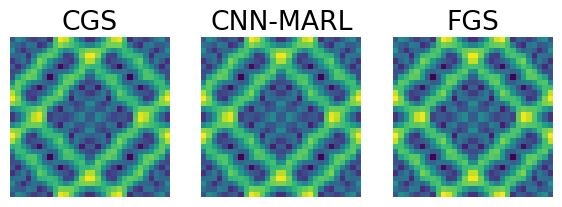

Num CGS steps: 21


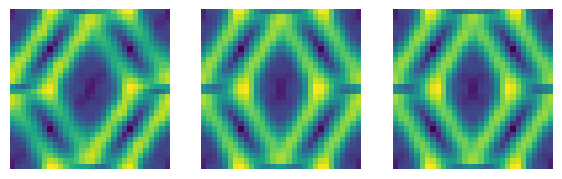

Num CGS steps: 41


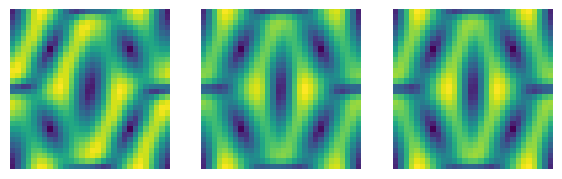

Num CGS steps: 61


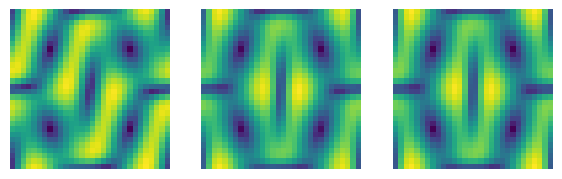

Num CGS steps: 81


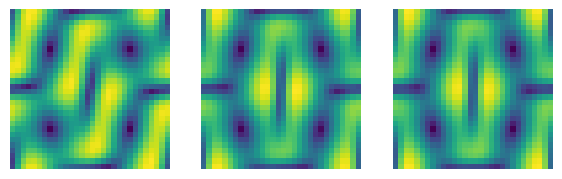

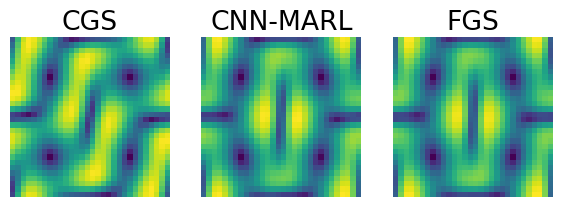

Collector( 
CGS: (100,), 
CNN-MARL: (100,), 
|u|_cgs: (100, 30, 30), 
|u|_cnn-marl: (100, 30, 30), 
)

In [11]:
SIM_LEN = 100
run_simulation_and_collect_velocities(SIM_LEN, num_imgs=5, do_plot=True, debug=False)

# Quantitative Results
## Simulation

In [98]:
NUM_SIMS = 10
NUM_STEPS = 10
col_names = ["CGS", "CNN-MARL", "|u|_cgs", "|u|_cnn-marl"]
col = Collector(col_names)

for i in tqdm(range(NUM_SIMS)):
    new_col = run_simulation_and_collect_velocities(num_steps=NUM_STEPS, do_plot=False)
    col.load_collection(new_col)
    
col.post_collection_processing()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.56it/s]


In [99]:
# Saving
_path = SAVE_PATH + f"{NUM_STEPS}steps_{NUM_SIMS}sims_{VEL_FIELD_TYPE}_evolution.pkl"
save_col(col, path=_path)

# Analysis

In [12]:
# Loading previously collected collection for visualization
NUM_SIMS = 100
NUM_STEPS = 400
_path = LOAD_PATH + f"{NUM_STEPS}steps_{NUM_SIMS}sims_{VEL_FIELD_TYPE}_evolution.pkl"
col = load_col(path=_path)


Threshold: 0.1
CNN-MARL: 134.3200 +- 58.0830 | (+4820.15%)
CGS: 2.7300 +- 1.8647 | (+0.00%)


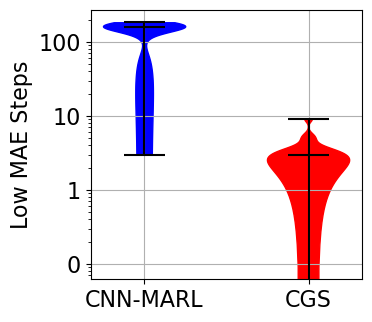

In [14]:
threshold = 0.1
categories = ["CNN-MARL", "CGS"]

# Collect raw data points for each category
data_points = [np.argmax(col(cat) > threshold, axis=1) for cat in categories]

plt.figure() 

# Set labels and titles
colors = [method_color[cat] for cat in categories]

# Create the violin plot
violin_parts = plt.violinplot(data_points, showmeans=False, showmedians=True)

# Apply colors to each violin
for i, body in enumerate(violin_parts['bodies']):
    body.set_color(colors[i])
    body.set_alpha(1)

violin_parts['cbars'].set_edgecolor('black') 
violin_parts['cmaxes'].set_edgecolor('black') 
violin_parts['cmins'].set_edgecolor('black') 
violin_parts['cmedians'].set_edgecolor('black') 

plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
#plt.ylim(bottom=10e-2)
plt.xticks(ticks=[1, 2], labels=categories)  # Adjust ticks to match the number of categories
plt.ylabel("Low MAE Steps")
plt.grid(True)
plt.tight_layout()
plt.savefig(FIG_PATH + f'low_MAE_{threshold}_violin{NUM_STEPS}steps_{NUM_SIMS}sims.pdf')

values = [np.mean(low_mae_simlen) for low_mae_simlen in data_points]
yerr = [np.std(low_mae_simlen) for low_mae_simlen in data_points]
cgs_value = values[-1]
print(f"\nThreshold: {threshold}")
for cat, value, std in zip(categories, values, yerr):
    print(f"{cat}: {value:.4f} +- {std:.4f} | (+{(value-cgs_value)/cgs_value:.2%})")

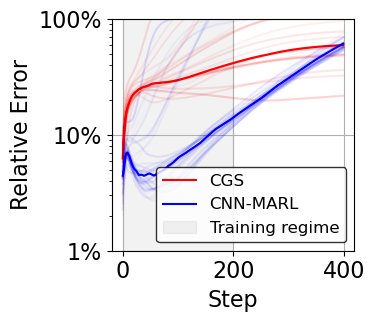

In [15]:
max_n = 400
N_TRAIN_MAX = 200
steps = range(max_n)
plt.figure() 
plot_collection_individuals(steps, 100 * col("CGS")[:,:max_n], label="CGS", color=method_color["CGS"], log=True, mode="median", alpha=.02)
plot_collection_individuals(steps, 100 * col("CNN-MARL")[:,:max_n], label="CNN-MARL", color=method_color["CNN-MARL"], log=True, mode="median", alpha=.02)
plt.axvspan(0, N_TRAIN_MAX, color='grey', alpha=0.1, label="Training regime")

plt.legend(loc='lower right', edgecolor='black')

# Settings of y ticks
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
ax.yaxis.set_major_formatter(ticker.PercentFormatter())

plt.ylim(bottom=1, top=100)
plt.grid(True)
plt.ylabel("Relative Error")
plt.xlabel("Step")
plt.tight_layout()
plt.savefig(FIG_PATH + f'relative_MAE_evol_{max_n}steps.pdf')  # Saving as PDF

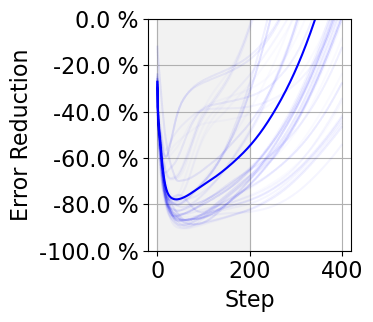

In [16]:
# Error reduction of CGS with CNN-MARL
plt.figure() 
steps = range(NUM_STEPS)
rel_abs_error = (col("CGS") - col("CNN-MARL")) / col("CGS")
plot_collection_individuals(steps, -100 * rel_abs_error, label="rel err", color="b", mode="mean", alpha=.02)
plt.axvspan(0, N_TRAIN_MAX, color='grey', alpha=0.1, label="training regime")
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x} %"))
plt.grid(True)
plt.tight_layout()
plt.ylim(top=0, bottom=-100)
plt.ylabel("Error Reduction")
plt.xlabel("Step")
plt.tight_layout()
plt.savefig(FIG_PATH + f'improvement_rel_MAE_evol_{SIM_LEN}steps.pdf')  # Saving as PDF

CGS: 0.3228 +- 0.1674 | (-0.00%) w.r.t. CGS
CNN-MARL: 0.0917 +- 0.1343 | (-71.60%) w.r.t. CGS


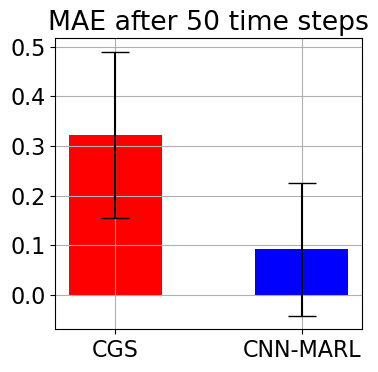

In [17]:
plt.figure(figsize=(4, 4)) 
EVAL_STEP = 50
cgs = col("CGS")[:, EVAL_STEP-1]
cnn_marl = col("CNN-MARL")[:, EVAL_STEP-1]

categories = ["CGS", "CNN-MARL"]
values = [cgs.mean(), cnn_marl.mean()]
yerr = [cgs.std(), cnn_marl.std()]
colors = [method_color[cat] for cat in categories]
plt.bar(categories, values, color=colors, yerr=yerr, width=0.5, capsize=10, log=False)
plt.title(f"MAE after {EVAL_STEP} time steps")
plt.grid(True)
plt.tight_layout()
plt.savefig(FIG_PATH + f'relative_MAE@{EVAL_STEP}.pdf')  # Saving as PDF

no_rl_error = cgs.mean()
for cat, value, std in zip(categories, values, yerr):
    print(f"{cat}: {value:.4f} +- {std:.4f} | (-{(no_rl_error - value)/no_rl_error:.2%}) w.r.t. CGS")

# GIF Generation

In [114]:
import imageio

def save_sim_to_gif(_col, names=None):
    gif_path = "gifs/"
    os.makedirs(os.path.dirname(gif_path), exist_ok=True)
    for sim in names:
        # convert from (0, 1) float to (0, 255) uint8
        normalizer = _col(sim).max(axis=(1, 2), keepdims=True)
        clipped_sim_frames = np.clip(_col(sim) / normalizer * 255, 0, 255)
        clipped_sim_frames = clipped_sim_frames.astype(np.uint8)
        imageio.mimsave(gif_path + f"{sim}.gif", clipped_sim_frames , format='GIF', fps=20)

Num CGS steps: 1


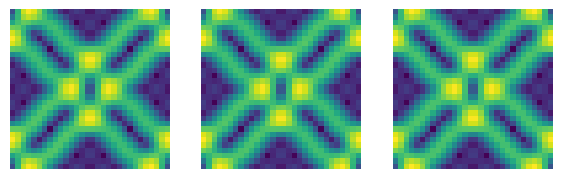

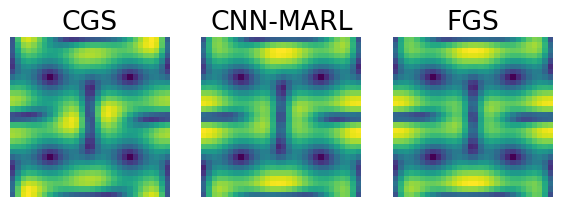

In [115]:
SIM_LEN = 100
vizualization_col = run_simulation_and_collect_velocities(num_steps=SIM_LEN, num_imgs=1, do_plot=True)
vizualization_col.post_collection_processing()

In [116]:
save_sim_to_gif(vizualization_col, names=["|u|_cgs", "|u|_cnn-marl"])

# Speed Tests

In [118]:
from time import time

NUM_SAMPLES = 500
time_col = Collector(["CGS", "CNN-MARL", "FGS"])

for _ in tqdm(range(NUM_SAMPLES)):
    obs, _ = env.reset()
    u_cgs_no_rl, v_cgs_no_rl = deepcopy(env.u_cgs), deepcopy(env.v_cgs)
    
    begin = time()
    env.fgs_step()
    fgs_time = time() - begin
    time_col.add("FGS", fgs_time)
    
    begin = time()
    u_cgs_no_rl, v_cgs_no_rl = env.burgers_time_step(u_cgs_no_rl, v_cgs_no_rl, env.viscosity, env.dx_cgs, env.dy_cgs, env.dt_cgs)
    cgs_time = time() - begin
    time_col.add("CGS", cgs_time)
    
    begin = time()
    action = actor.get_action_mean(obs).detach().squeeze().cpu().numpy().clip(-1, 1)
    env.u_cgs = np.clip(env.u_cgs - env.dt_cgs * action[0], env.observation_space.low, env.observation_space.high)
    env.v_cgs = np.clip(env.v_cgs - env.dt_cgs * action[1], env.observation_space.low, env.observation_space.high)
    env.cgs_step()
    cnn_marl_time = time() - begin
    time_col.add("CNN-MARL", cnn_marl_time)

time_col.post_collection_processing()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:17<00:00, 28.50it/s]


FGS: 12.80 +- 0.23 ms
CNN-MARL: 2.17 +- 0.07 ms
CGS: 0.36 +- 0.01 ms

CGS step time improvement of -97.22% w.r.t. FGS
CNN-MARL step time improvement of -83.05% w.r.t. FGS


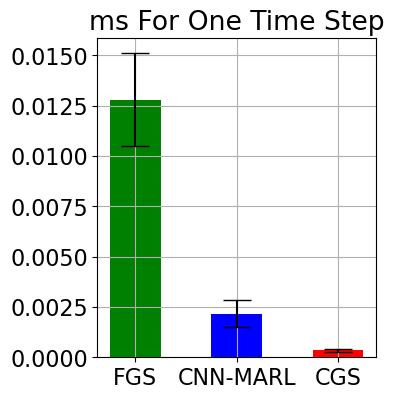

In [135]:
plt.figure(figsize=(4, 4)) 

categories = ["FGS", "CNN-MARL", "CGS"]
values = [time_col(cat).mean() for cat in categories]
yerr = [time_col(cat).std() for cat in categories]
colors = [method_color[cat] for cat in categories]
plt.bar(categories, values, color=colors, yerr=yerr, width=0.5, capsize=10, log=False)
plt.grid(True)
plt.tight_layout()
plt.title("ms For One Time Step")
#plt.yscale("log")

for cat, value, std in zip(categories, values, yerr):
    print(f"{cat}: {1000 * value:.2f} +- {100 * std:.2f} ms")

cgs_time = time_col("CGS").mean()
fgs_time = time_col("FGS").mean()
cnn_marl_time = time_col("CNN-MARL").mean()
print(f"\nCGS step time improvement of -{(fgs_time-cgs_time) / fgs_time :.2%} w.r.t. FGS")
print(f"CNN-MARL step time improvement of -{(fgs_time-cnn_marl_time) / fgs_time :.2%} w.r.t. FGS")